In [2]:
import numpy as np
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
from matplotlib import gridspec
import astropy.units as u
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from spec_exam import Gen_spec_2D
import fsps
from time import time
from spec_id import *
from spec_id_2d import *
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



In [261]:
adb = pd.read_pickle('../dataframes/fitdb/evolution_db.pkl')
Adb = adb.query('AGN != "AGN" and lmass > 10 and concen < -0.4 and 0.7 < zgrism < 2.7 and Z > 0')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


197
58
470


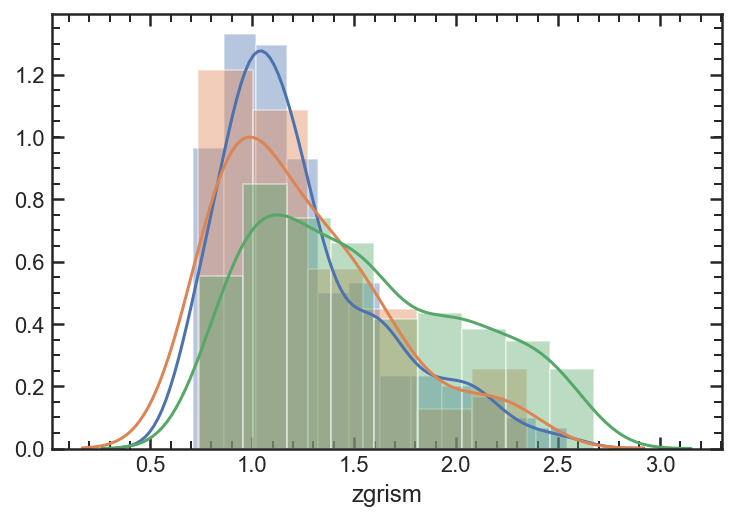

In [4]:
sea.distplot(Adb.query('sf_prob < 0.2').zgrism)
sea.distplot(Adb.query('0.2 < sf_prob < 0.8').zgrism)
sea.distplot(Adb.query('sf_prob > 0.8').zgrism)

print(len(Adb.query('sf_prob < 0.2')))
print(len(Adb.query('0.2 < sf_prob < 0.8')))
print(len(Adb.query('sf_prob > 0.8')))


In [28]:
from spec_id import Calibrate_grism, Scale_model
def Q_spec_adjust():
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 1)
    sp.params['dust2'] = fit_db['bfd'].values[0]
    sp.params['dust1'] = fit_db['bfd'].values[0]
    sp.params['logzsol'] = np.log10(fit_db['bfm'].values[0])
    
    time, sfr, tmax = convert_sfh(get_agebins(fit_db['bfa'].values[0]), 
        [fit_db['bfm1'].values[0], fit_db['bfm2'].values[0], fit_db['bfm3'].values[0], 
         fit_db['bfm4'].values[0], fit_db['bfm5'].values[0], 
         fit_db['bfm6'].values[0],fit_db['bfm7'].values[0], fit_db['bfm8'].values[0], 
         fit_db['bfm9'].values[0], fit_db['bfm10'].values[0]], maxage = fit_db['bfa'].values[0]*1E9)

    sp.set_tabular_sfh(time,sfr) 

    wave, flux = sp.get_spectrum(tage = fit_db['bfa'].values[0], peraa = True)
    flam = F_lam_per_M(flux,wave*(1 + specz), specz, 0, sp.stellar_mass)*10**fit_db['bflm'].values[0]
    
    return wave, flam, sp

def SF_spec_adjust():
    sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
    sp.params['dust1'] = 0
    sp.params['dust2'] = fit_db['bfd'].values[0]
    sp.params['logzsol'] = np.log10(fit_db['bfm'].values[0])

    time, sfr, tmax = convert_sfh(get_agebins(fit_db['bfa'].values[0], binnum = 6), 
        [fit_db['bfm1'].values[0], fit_db['bfm2'].values[0], fit_db['bfm3'].values[0], fit_db['bfm4'].values[0], fit_db['bfm5'].values[0], 
         fit_db['bfm6'].values[0]], maxage = fit_db['bfa'].values[0]*1E9)

    sp.set_tabular_sfh(time,sfr) 

    wave, flux = sp.get_spectrum(tage = fit_db['bfa'].values[0], peraa = True)
    flam = F_lam_per_M(flux,wave*(1 + specz), specz, 0, sp.stellar_mass)*10**fit_db['bflm'].values[0]
    
    return wave, flam, sp

In [202]:
def Stack(wv, flxgrid , errgrid):
    flgrid = np.transpose(flxgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))        
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    ################
    
    return stack, err

def stack_setup(db, swave):
    flxgrid = []
    errgrid = []

    for i in db.index:
        ffl = np.zeros_like(swave).astype(float)
        fer = np.zeros_like(swave).astype(float)
        try:
            sp = np.load('../full_specs/{}_{}_fullspec.npy'.format(db.field[i], db.id[i]), allow_pickle=True).item()
            IDX = [U for U in range(len(sp['wave'])) if 4200 < sp['wave'][U] < 6000]
            Nfact = np.trapz(sp['flam'][IDX],sp['wave'][IDX])

            if len(sp['Bwv']) > 0:
                bwv = sp['Bwv'] / (1 + db.zgrism[i])
                bfl = interp1d(bwv,sp['Bfl']/Nfact, fill_value=0, bounds_error=False)(swave)
                ber = interp1d(bwv,sp['Ber']/Nfact, fill_value=0, bounds_error=False)(swave)
                ffl += bfl
                fer += ber

            if len(sp['Rwv']) > 0:
                rwv = sp['Rwv'] / (1 + db.zgrism[i])
                rfl = interp1d(rwv,sp['Rfl']/Nfact, fill_value=0, bounds_error=False)(swave)
                rer = interp1d(rwv,sp['Rer']/Nfact, fill_value=0, bounds_error=False)(swave)
                ffl += rfl
                fer += rer
            fer[fer == 0] = 1
            flxgrid.append(ffl)
            errgrid.append(fer)   
        except:
    #         print(field, galaxy)
            pass

    
    return Stack(swave, flxgrid, errgrid)

def plot_spec(ax,wv,fl,er, lim1, lim2, color):
    IDS = [U for U in range(len(wv)) if lim1 < wv[U] < lim2]
    ax.errorbar(wv[IDS], fl[IDS], er[IDS], linestyle = 'none', color=color,)
    # O
    ax.axvline(3727.092 ,linestyle='--', alpha=0.3, color = 'b', linewidth = 2)
    ax.axvline(5008.240,linestyle='--', alpha=0.3, color = 'b', linewidth = 2)
    # Balmer
    ax.axvline(4102.89 ,linestyle='--', alpha=0.3, color = 'r', linewidth = 2)
    ax.axvline(4341.68 ,linestyle='--', alpha=0.3, color = 'r', linewidth = 2)
    ax.axvline(4862.68 ,linestyle='--', alpha=0.3, color = 'r', linewidth = 2)
    ax.axvline(6564.61 ,linestyle='--', alpha=0.3, color = 'r', linewidth = 2)

    ax.axvline(6718.29,linestyle='--', alpha=0.3, color = 'b', linewidth = 2) #SII
#     ax.axvline(2799.117,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) # MgII

    ax.axvline(3934,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) # H
    ax.axvline(3969,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) # K
    ax.axvline(4305,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) # G

    ax.axvline(5176.7,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) # Mg
    ax.axvline(5895.6,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) #Na
    ax.axvline(8500,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) #CaII
    ax.axvline(8544,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) #CaII
    ax.axvline(8664,linestyle='-', alpha=0.3, color = 'k', linewidth = 2) #CaII
    ax.set_xlim(lim1*0.95, lim2*1.01)

In [199]:
print(len(Adb.query('sf_prob_2 > 0.8 and 0.7 < zgrism < 1.5')))
print(len(Adb.query('sf_prob_2 > 0.8 and 1.5 < zgrism < 2.7')))
print(len(Adb.query('0.2 < sf_prob_2 < 0.8 and 0.7 < zgrism < 1.5')))
print(len(Adb.query('0.2 < sf_prob_2 < 0.8 and 1.5 < zgrism < 2.7')))
print(len(Adb.query('sf_prob_2 < 0.2 and 0.7 < zgrism < 1.5')))
print(len(Adb.query('sf_prob_2 < 0.2 and 1.5 < zgrism < 2.7')))

286
217
31
21
122
48


In [223]:
swave = np.arange(1000,10000,10)
full_db = pd.read_pickle('../dataframes/fitdb/all_galaxies_1d.pkl')

s1_flx, s1_err = stack_setup(Adb.query('sf_prob_2 > 0.8 and 0.7 < zgrism < 1.5'), swave)
s2_flx, s2_err = stack_setup(Adb.query('sf_prob_2 > 0.8 and 1.5 < zgrism < 2.7'), swave)

s3_flx, s3_err = stack_setup(Adb.query('0.2 < sf_prob_2 < 0.8 and 0.7 < zgrism < 1.5'), swave)
s4_flx, s4_err = stack_setup(Adb.query('0.2 < sf_prob_2 < 0.8 and 1.5 < zgrism < 2.7'), swave)

s5_flx, s5_err = stack_setup(Adb.query('sf_prob_2 < 0.2 and 0.7 < zgrism < 1.5'), swave)
s6_flx, s6_err = stack_setup(Adb.query('sf_prob_2 < 0.2 and 1.5 < zgrism < 2.7'), swave)

[]

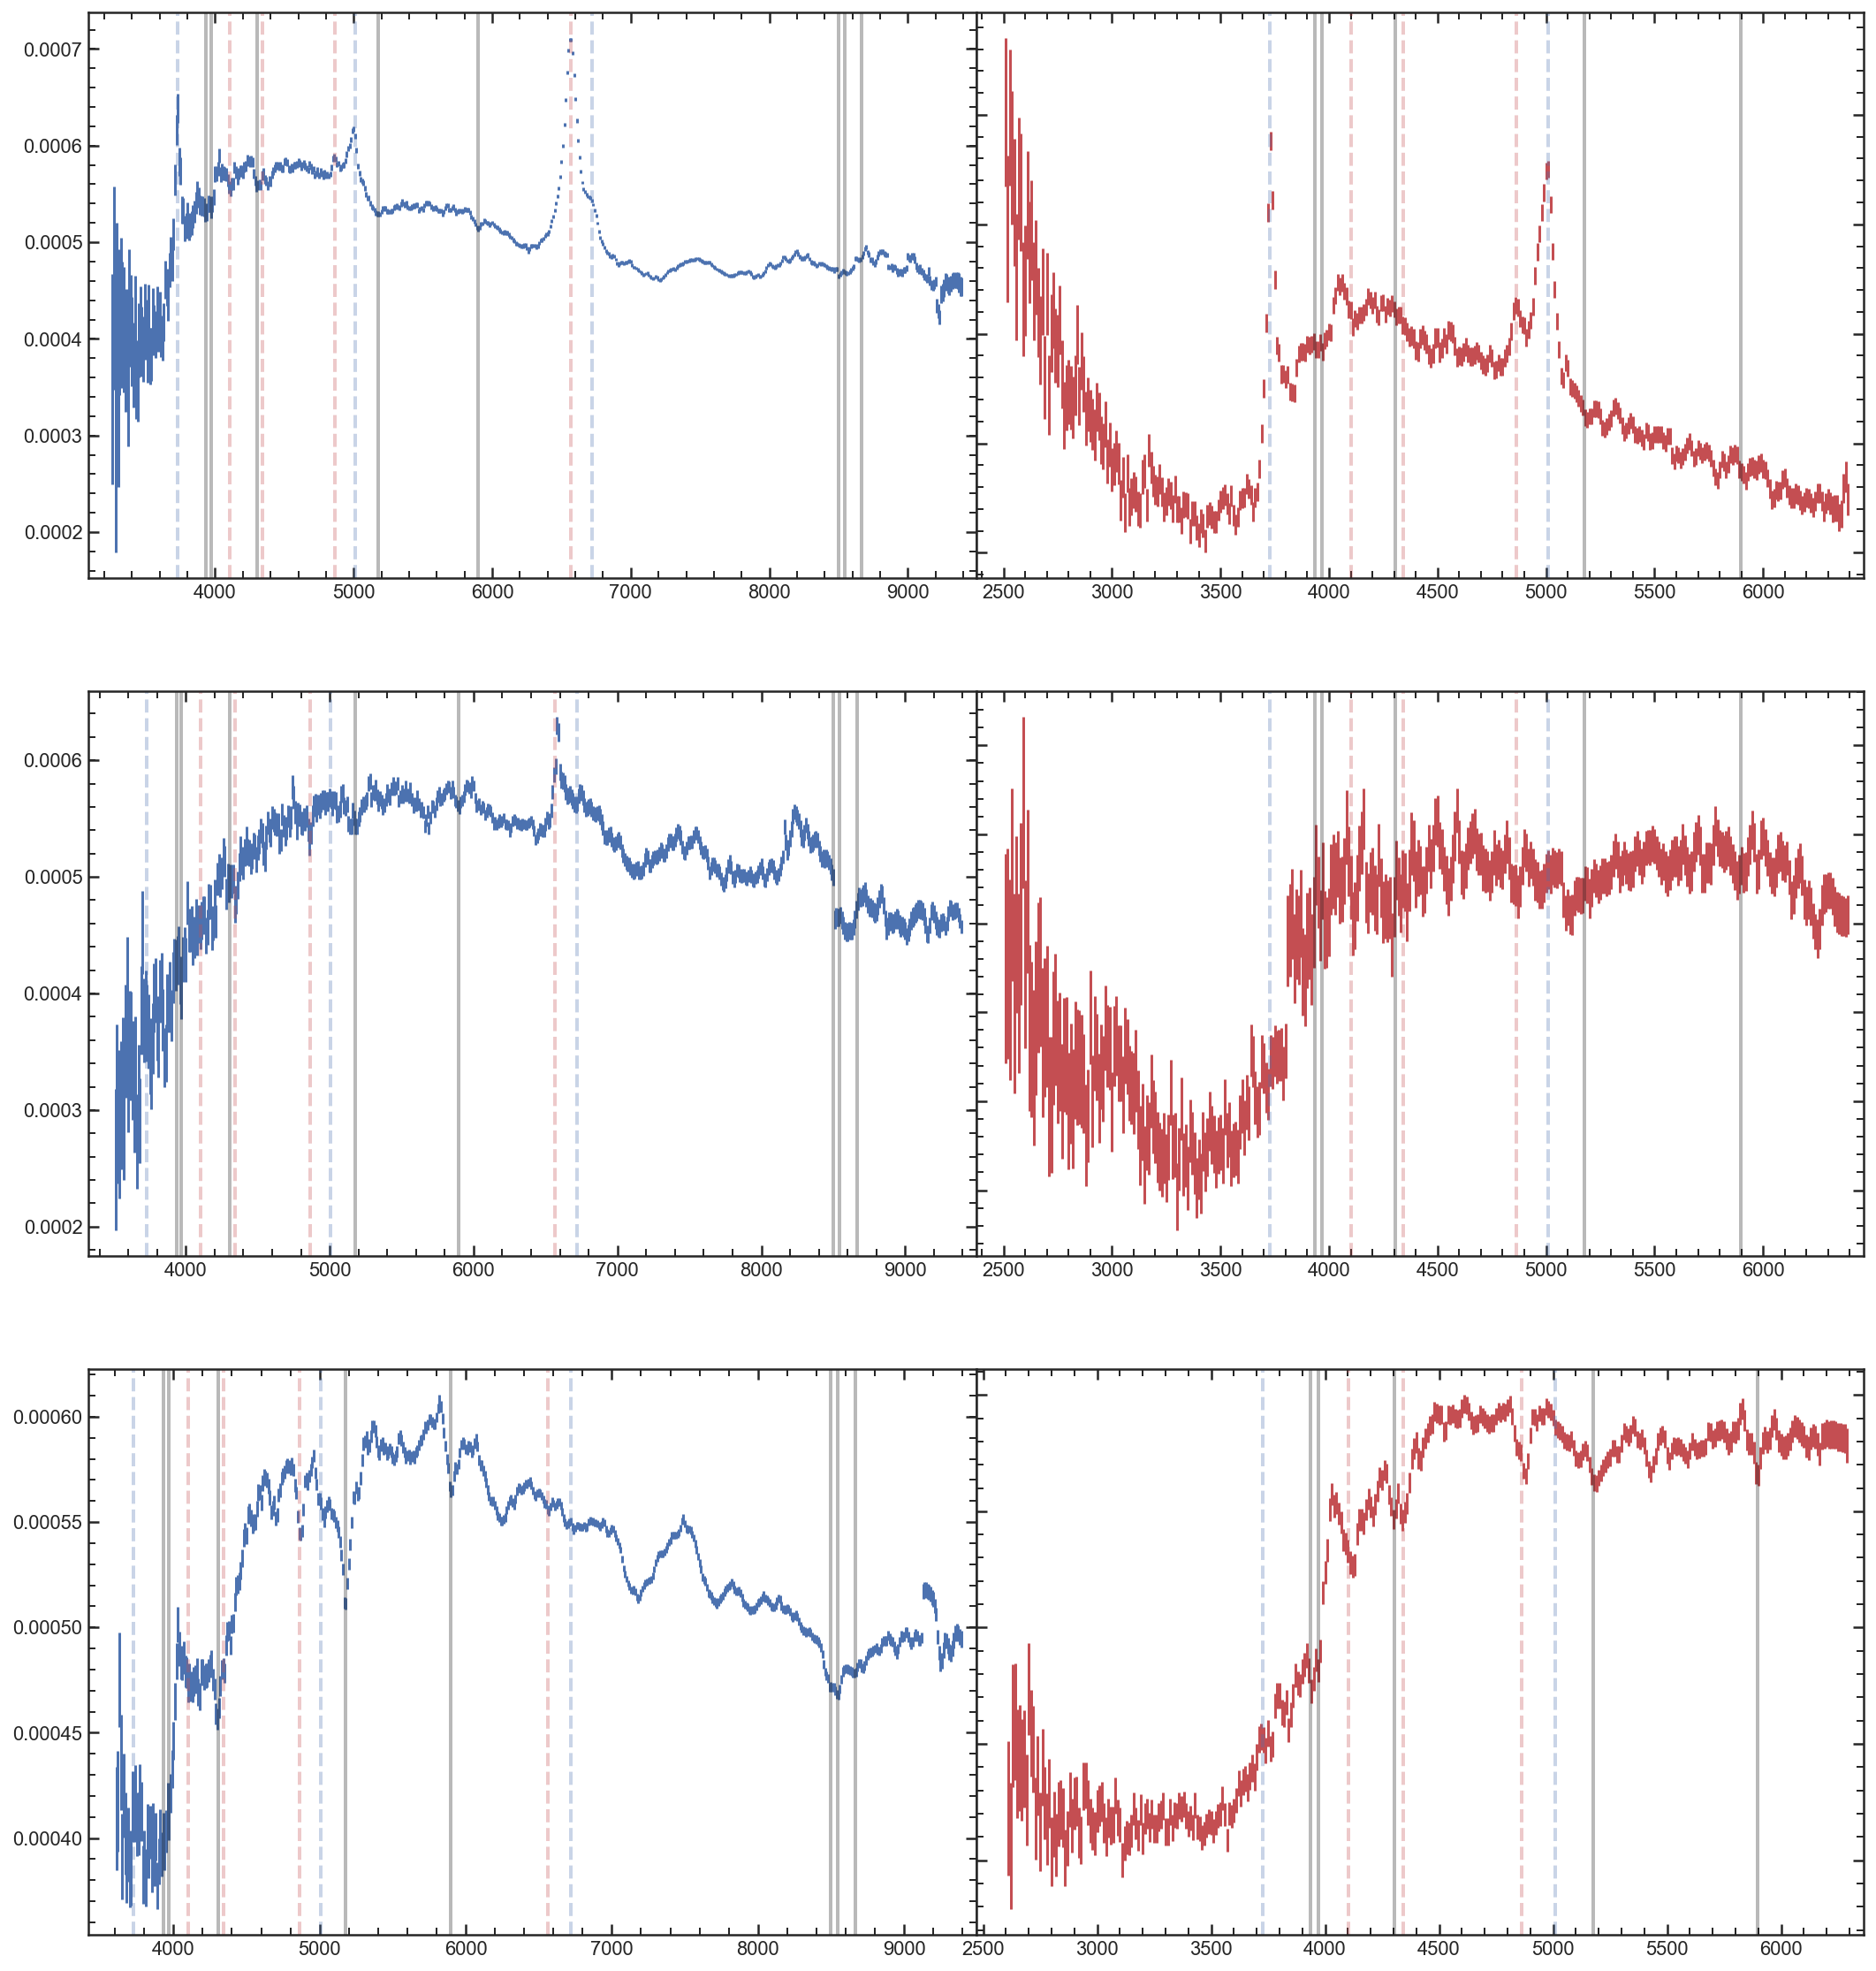

In [224]:
gs = gridspec.GridSpec(3,2,wspace=0)
    
plt.figure(figsize=[18,20])
ax1=plt.subplot(gs[0]);ax2=plt.subplot(gs[1]);ax3=plt.subplot(gs[2]);ax4=plt.subplot(gs[3])
ax5=plt.subplot(gs[4]);ax6=plt.subplot(gs[5])

plot_spec(ax1, swave, s1_flx, s1_err, 3250, 9400, 'b')
plot_spec(ax2, swave, s2_flx, s2_err, 2500, 6400, 'r')

plot_spec(ax3, swave, s3_flx, s3_err, 3500, 9400, 'b')
plot_spec(ax4, swave, s4_flx, s4_err, 2500, 6400, 'r')

plot_spec(ax5, swave, s5_flx, s5_err, 3600, 9400, 'b')
plot_spec(ax6, swave, s6_flx, s6_err, 2600, 6300, 'r')

ax2.set_yticklabels([]);ax4.set_yticklabels([]);ax6.set_yticklabels([])


In [213]:
swave = np.arange(1000,10000,10)
full_db = pd.read_pickle('../dataframes/fitdb/all_galaxies_1d.pkl')

# s1_flx, s1_err = stack_setup(Adb.query('sf_prob_2 < 0.2 and 9 < log_Sigma1 < 10.'), swave)
# s2_flx, s2_err = stack_setup(Adb.query('sf_prob_2 < 0.2 and 10 < log_Sigma1 < 10.25'), swave)
# s3_flx, s3_err = stack_setup(Adb.query('sf_prob_2 < 0.2 and log_Sigma1 > 10.25'), swave)
s1_flx, s1_err = stack_setup(Adb.query('8 < log_Sigma1 < 9'), swave)
s2_flx, s2_err = stack_setup(Adb.query('9 < log_Sigma1 < 10.'), swave)
s3_flx, s3_err = stack_setup(Adb.query('10 < log_Sigma1 < 10.25'), swave)
s4_flx, s4_err = stack_setup(Adb.query('log_Sigma1 > 10.25'), swave)

(2470.0, 9494.0)

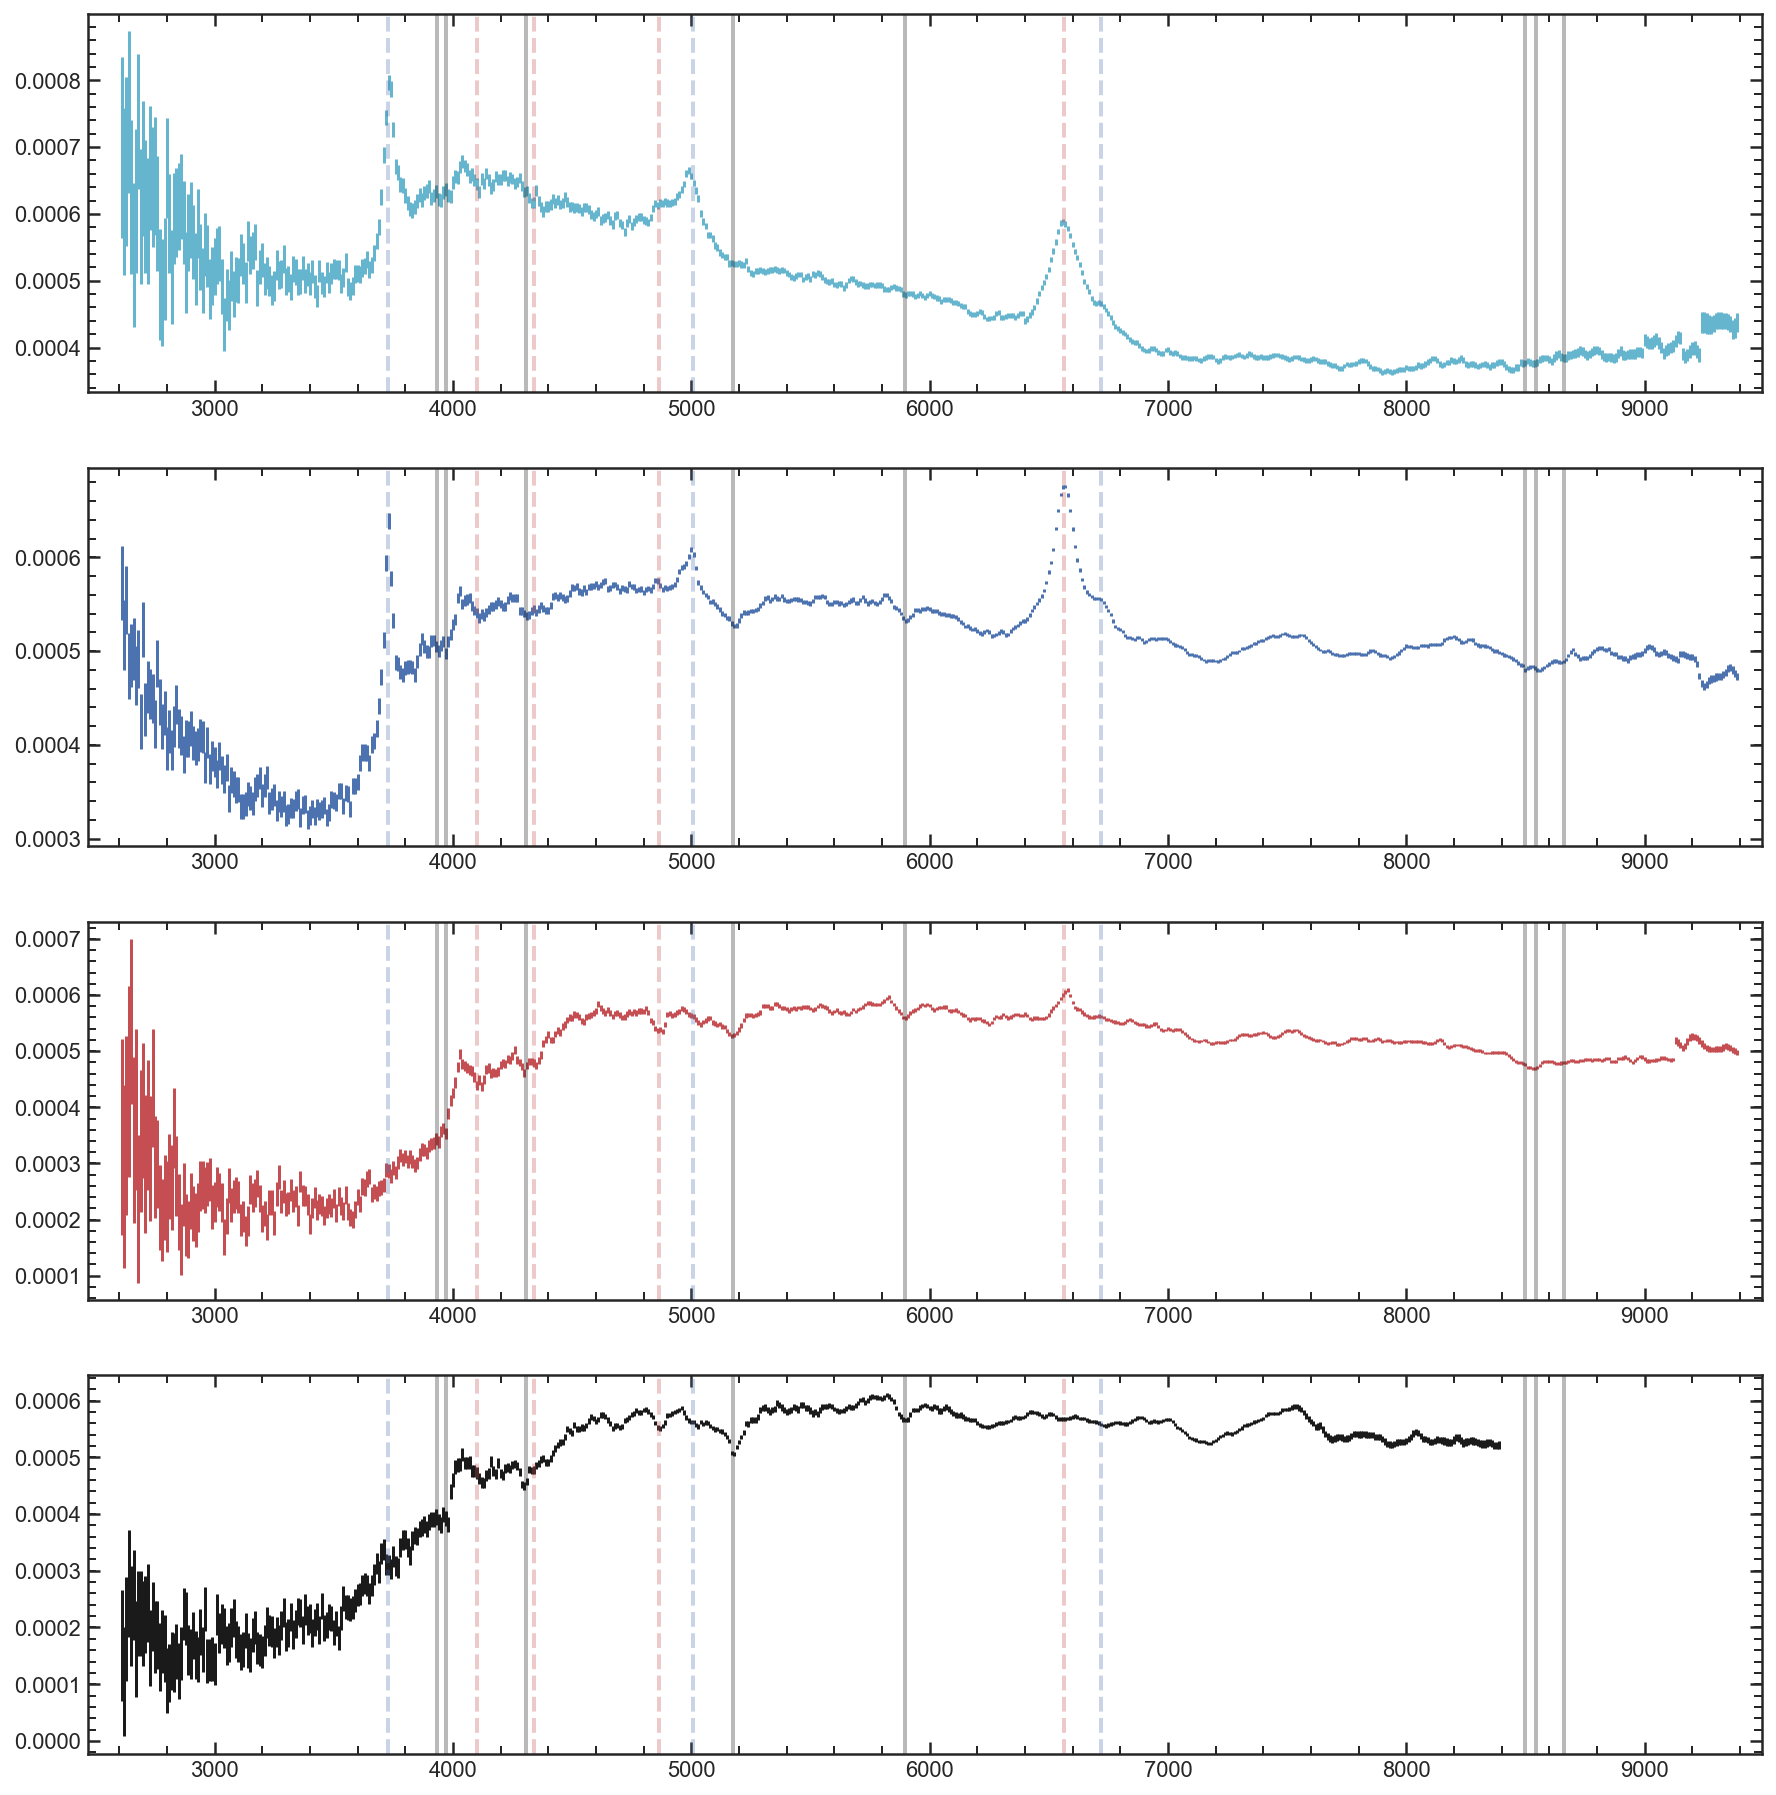

In [221]:
gs = gridspec.GridSpec(4,1)
    
plt.figure(figsize=[15,16])
ax1=plt.subplot(gs[0]);ax2=plt.subplot(gs[1]);ax3=plt.subplot(gs[2]);ax4=plt.subplot(gs[3])
plot_spec(ax1, swave, s1_flx, s1_err, 2600, 9400, 'c')
plot_spec(ax2, swave, s2_flx, s2_err, 2600, 9400, 'b')
plot_spec(ax3, swave, s3_flx, s3_err, 2600, 9400, 'r')
plot_spec(ax4, swave, s4_flx, s4_err, 2600, 8400, 'k')
ax4.set_xlim(2600 *.95, 9400*1.01)

In [252]:
def Stack_SFH(db):
    import pickle
    from make_sfh_tool import Gen_SFH
    LBT = np.linspace(0,14, 1000)
    LBT_50 = np.linspace(-10,10, 1000)

    SFH_grid = []
    SFH_50_grid = []

    for i in db.index:
        try:
            lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(db.field[i], db.id[i]))

        except:
            try:
                with open('../data/SFH/{}_{}.pkl'.format(db.field[i], db.id[i]), 'rb') as sfh_file:
                    sfh = pickle.load(sfh_file)
                lbt = sfh.LBT 
                sfh = sfh.SFH 

            except:
                with open('../data/SFH/{}_{}_1D.pkl'.format(db.field[i], db.id[i]), 'rb') as sfh_file:
                    sfh = pickle.load(sfh_file)
                lbt = sfh.LBT 
                sfh = sfh.SFH                
        isfh = interp1d(lbt+cosmo.lookback_time(db.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
        SFH_grid.append(isfh/ np.trapz(isfh, LBT))
        isfh = interp1d(lbt - db.t_50[i],sfh, bounds_error=False, fill_value=0)(LBT_50)
        SFH_50_grid.append(isfh/ np.trapz(isfh, LBT_50))

    M_SFH = np.percentile(SFH_grid, 50, axis =0)
    L_SFH = np.percentile(SFH_grid, 16, axis =0)
    H_SFH = np.percentile(SFH_grid, 84, axis =0)

    M_SFH_50 = np.percentile(SFH_50_grid, 50, axis =0)
    L_SFH_50 = np.percentile(SFH_50_grid, 16, axis =0)
    H_SFH_50 = np.percentile(SFH_50_grid, 84, axis =0)

    return LBT[H_SFH > 0], M_SFH[H_SFH > 0], L_SFH[H_SFH > 0], H_SFH[H_SFH > 0], \
        LBT_50[H_SFH_50 > 0], M_SFH_50[H_SFH_50 > 0], L_SFH_50[H_SFH_50 > 0], H_SFH_50[H_SFH_50 > 0]

In [274]:
LT1, M1, L1, H1, LT1_50, M1_50, L1_50, H1_50 = Stack_SFH(Adb.query('sf_prob_2 < 0.2 and log_Sigma1 > 10.25')) 
LT2, M2, L2, H2, LT2_50, M2_50, L2_50, H2_50 = Stack_SFH(Adb.query('sf_prob_2 < 0.2 and  10 < log_Sigma1 < 10.25')) 
LT3, M3, L3, H3, LT3_50, M3_50, L3_50, H3_50 = Stack_SFH(Adb.query('sf_prob_2 < 0.2 and  8 < log_Sigma1 < 10.')) 

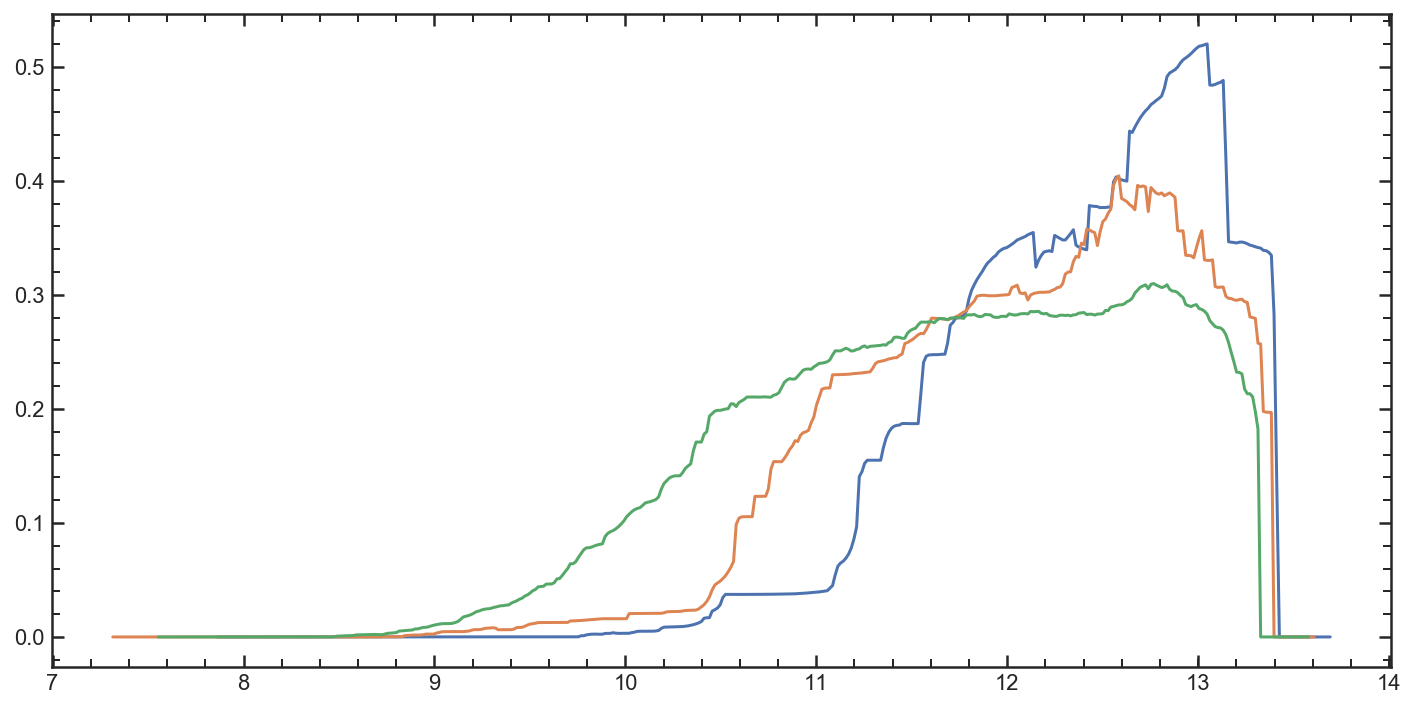

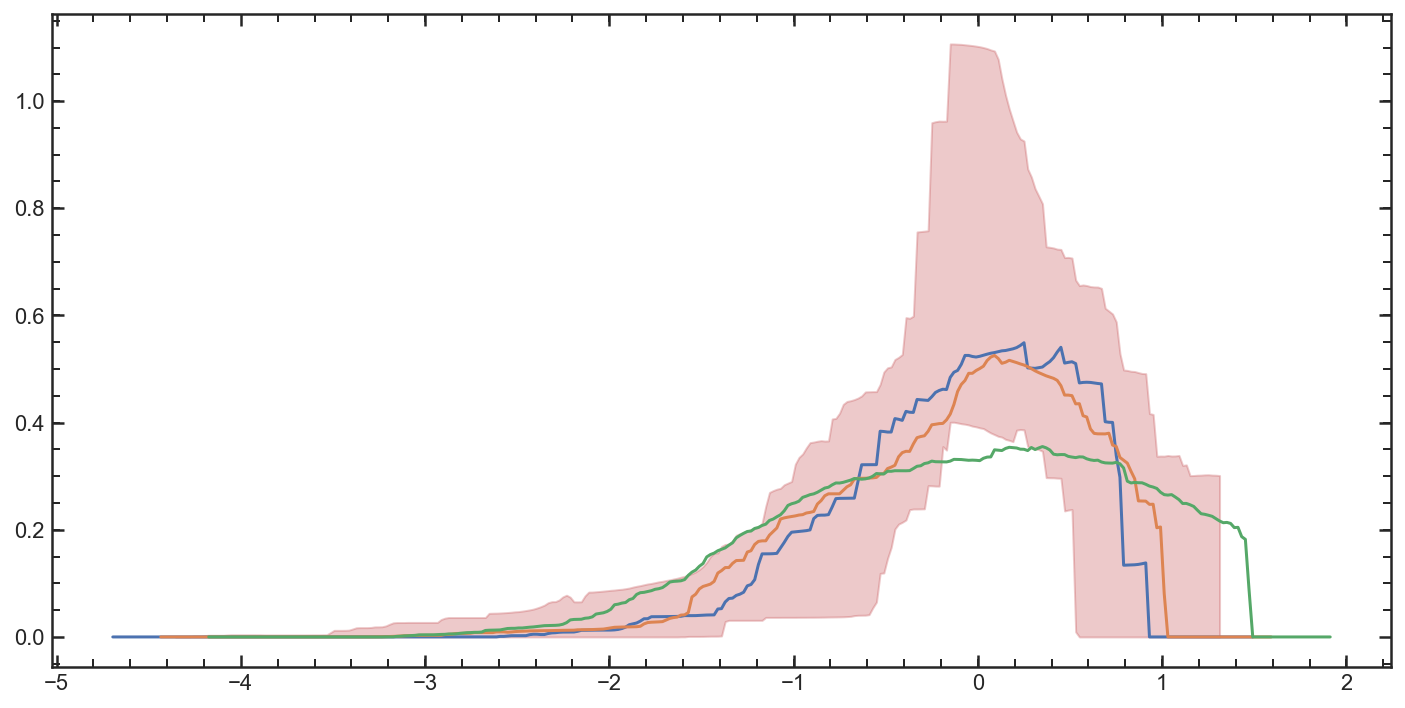

In [275]:

plt.figure(figsize=[12,6])
plt.plot(LT1, M1)
plt.plot(LT2, M2)
plt.plot(LT3, M3)

# plt.fill_between(LT, L, H, color = 'r', alpha = 0.3)

plt.figure(figsize=[12,6])
plt.plot(LT1_50, M1_50)
plt.plot(LT2_50, M2_50)
plt.plot(LT3_50, M3_50)
plt.fill_between(LT_50, L_50, H_50, color = 'r', alpha = 0.3)

In [270]:
for i in adb.index:
    if not os.path.isfile('../data/SFH/{0}_{1}.npy'.format(adb.field[i], adb.id[i])):
        try:
            with open('../data/SFH/{}_{}.pkl'.format(adb.field[i], adb.id[i]), 'rb') as sfh_file:
                sfh = pickle.load(sfh_file)
            lbt = sfh.LBT 
            sfh = sfh.SFH 
            np.save('../data/SFH/{0}_{1}'.format(adb.field[i], adb.id[i]), [lbt,sfh])
        except:
            try:
#                 with open('../data/SFH/{}_{}_p2_1D.pkl'.format(adb.field[i], adb.id[i]), 'rb') as sfh_file:
#                     sfh = pickle.load(sfh_file)
#             else:
                with open('../data/SFH/{}_{}_1D.pkl'.format(adb.field[i], adb.id[i]), 'rb') as sfh_file:
                    sfh = pickle.load(sfh_file)
                lbt = sfh.LBT 
                sfh = sfh.SFH        
                np.save('../data/SFH/{0}_{1}'.format(adb.field[i], adb.id[i]), [lbt,sfh])

            except:
                pass

In [ ]:
ls ../data/SFH/GSD_47399_1D.pkl